## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

Text(0, 0.5, 'Number of Tokens')

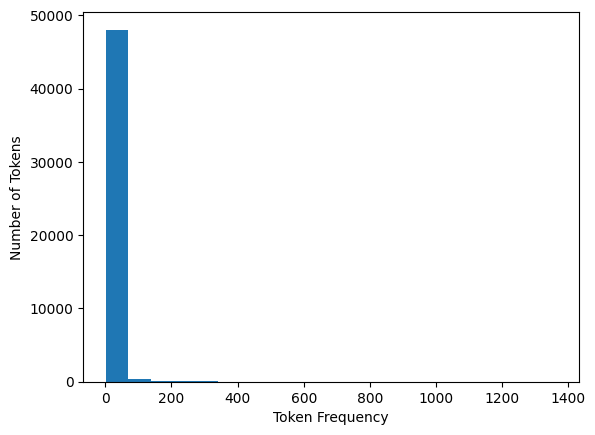

In [6]:
frequencies = list(token_count.values())
plt.hist(frequencies, bins=20)
plt.xlabel('Token Frequency')
plt.ylabel('Number of Tokens')

The histogram shows that the distribution of the fequency of toke occurrence is heavily-skewed right. It is more common for tokens to be rare or occur less. There are much fewer tokens that have high frequency.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [9]:
phish_df = pd.read_parquet('Phishing_clean.parquet')

In [10]:
# Q2. 1
from sklearn.model_selection import train_test_split

X = phish_df.drop(columns=['Email Type'])
y = phish_df['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [22]:
#Q2.2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("R² on Training Set: ")
print(r2_train)
print("R² on Test Set: ")
print(r2_test)


R² on Training Set: 
0.7690024352137449
R² on Test Set: 
0.656091227824831


In [14]:
#Q2.3

coef_df = pd.DataFrame({
    'token': X.columns,
    'coefficient': model.coef_
})

coef_df['abs_coef'] = coef_df['coefficient'].abs()
top_tokens = coef_df.sort_values(by='abs_coef', ascending=False).head(10)

print(top_tokens)


                  token  coefficient  abs_coef
906               aging     0.978736  0.978736
1504  background-image:    -0.899862  0.899862
740           localized     0.883348  0.883348
2362            thermal     0.654348  0.654348
1511            burning    -0.569892  0.569892
2182          reversing    -0.553977  0.553977
1302           erectile     0.532517  0.532517
1145             issue:    -0.521273  0.521273
2532             xanaax     0.494711  0.494711
818                cnet    -0.478445  0.478445


The words with the largest coefficients in absolute value are “aging,” “background-image:,” “localized,” “thermal,” and “burning.” Because they have the largest coefficients in absolute value, they most strongly influence the predictors.



### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

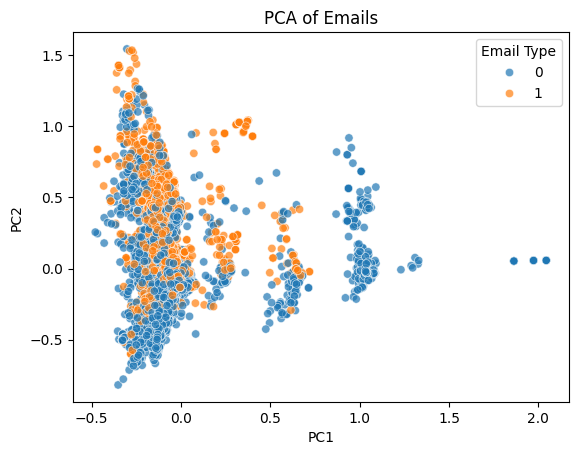

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Email Type': y
})

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', alpha=0.7)
plt.title('PCA of Emails')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


For the most part, the points for phishing emails and legitimate emails heavily overlap. This suggests that the first two principal components do not fully separate the two classes. There is some separation of legitimate email points. There also appears to be some outliers.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [21]:
pca = PCA(n_components=2610)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

y_train_pred_pca = lr_pca.predict(X_train_pca)
y_test_pred_pca = lr_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

print("R² on Training Set (PCA): ")
print(r2_train_pca)
print("R² on Test Set (PCA): ")
print(r2_test_pca)


R² on Training Set (PCA): 
0.7683356732439666
R² on Test Set (PCA): 
0.6560587522479737


The linear regression on the first 2610 principal components achieves slightly lower training R^2 compared to the regression on the original one-hot-encoded tokens. The test R^2 is slightly higher, indicating better generalization. This is because PCA removes components with very low variance, reducing noise and overfitting.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The main advantage of using principal components is that it reduces the number of features and combines the correlated words into a smaller set of components. Doing this reduces the risk of the model fitting to random noise, meaning generalization will be better. The model can still capture patterns in the data and usually will perform better on new test data.